<a href="https://colab.research.google.com/github/nastyaivt/MO/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F%205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ЛАБОРАТОРНАЯ РАБОТА: КЛАСТЕРИЗАЦИЯ ДАННЫХ USER KNOWLEDGE MODELING
Создаем пример данных для демонстрации
Размерность данных: (400, 6)

Первые 5 строк данных:
        STG       SCG       STR       LPR       PEG  UNS
0  0.496714 -0.138264  0.647689  1.523030 -0.234153    1
1 -0.234137  1.579213  0.767435 -0.469474  0.542560    1
2 -0.463418 -0.465730  0.241962 -1.913280 -1.724918    0
3 -0.562288 -1.012831  0.314247 -0.908024 -1.412304    0
4  1.465649 -0.225776  0.067528 -1.424748 -0.544383    1

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     400 non-null    float64
 1   SCG     400 non-null    float64
 2   STR     400 non-null    float64
 3   LPR     400 non-null    float64
 4   PEG     400 non-null    float64
 5   UNS     400 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 18.9 KB
None
Масштабирование призна

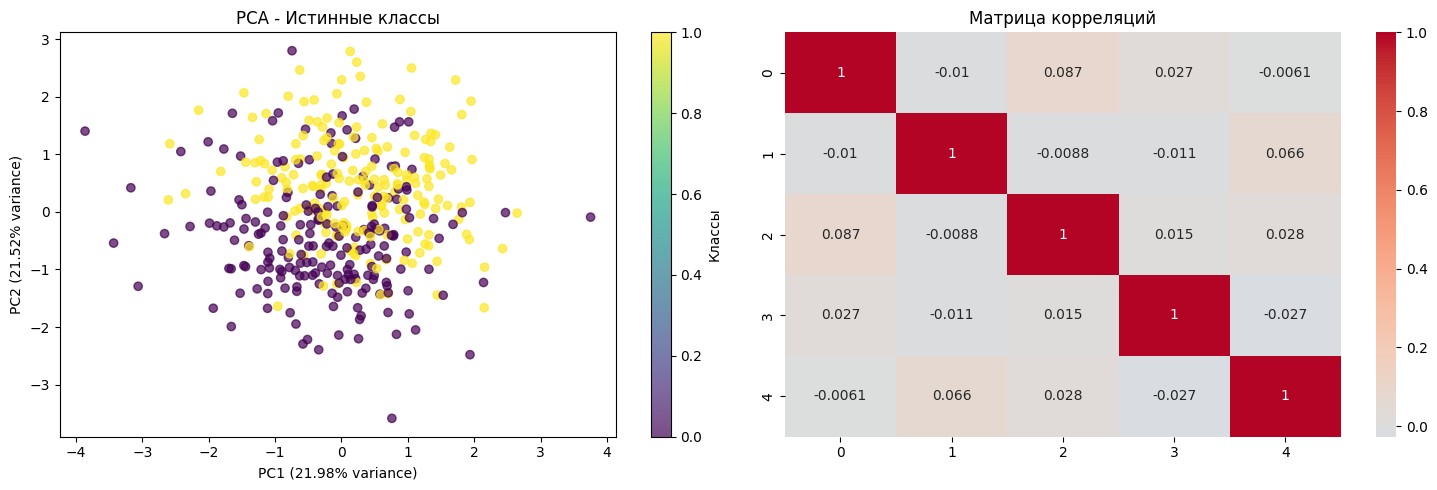

ЭКСПЕРИМЕНТ 1: K-MEANS КЛАСТЕРИЗАЦИЯ


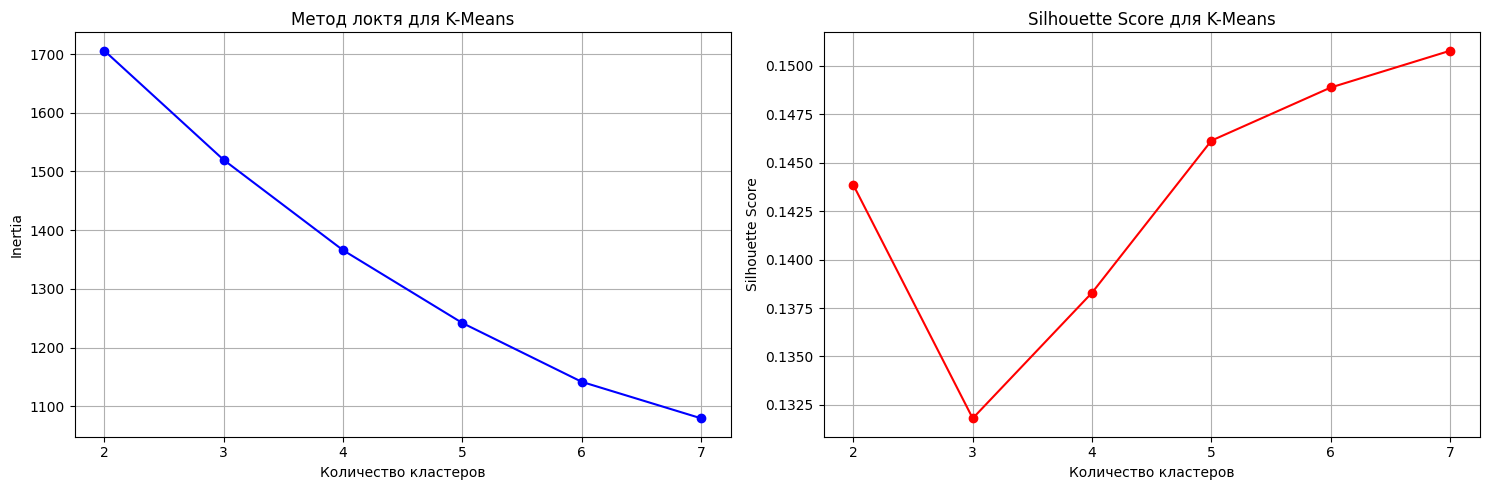

K-Means с 3 кластерами:
Silhouette Score: 0.1318
Adjusted Rand Index: 0.0870


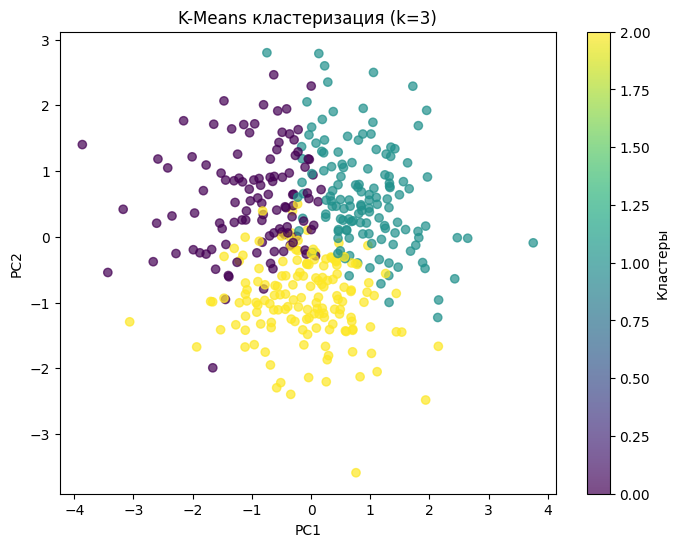


ЭКСПЕРИМЕНТ 2: DBSCAN КЛАСТЕРИЗАЦИЯ
Результаты подбора параметров DBSCAN:
    eps  min_samples  n_clusters  silhouette  noise_points
9   0.7            5           3    0.342306           386
8   0.7            3          10    0.297594           339
13  1.0            5           2    0.159684           175
16  1.2            3           4    0.022207            67
12  1.0            3           5   -0.003835           133

DBSCAN с eps=0.7, min_samples=5:
Количество кластеров: 3
Точек шума: 386
Silhouette Score: 0.3423
Adjusted Rand Index: 0.0313


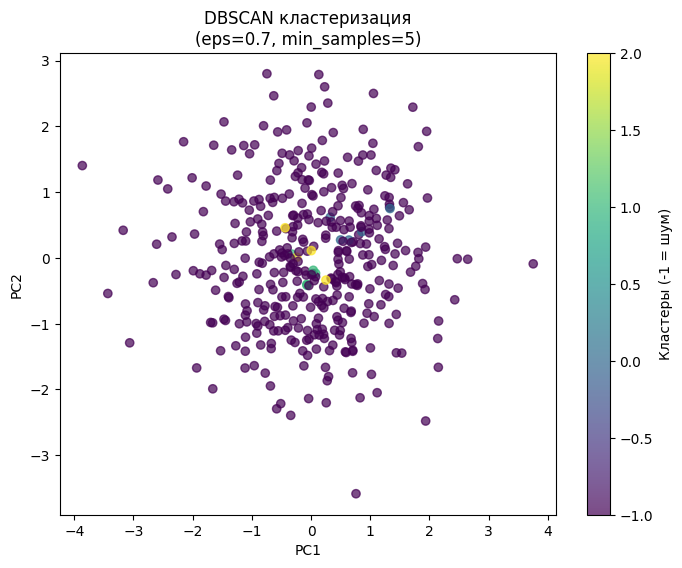


ЭКСПЕРИМЕНТ 3: GAUSSIAN MIXTURE MODELS (GMM)
Результаты подбора параметров GMM:
    n_components covariance_type  silhouette          bic
2              2            diag    0.143202  5796.308612
0              2       spherical    0.135432  5751.549555
1              2            tied    0.133856  5826.435235
13             5            tied    0.130753  5911.809281
12             5       spherical    0.128510  5856.645670

GMM с 2 компонентами, covariance_type='diag':
Silhouette Score: 0.1432
BIC (Bayesian Information Criterion): 5796.3086
Adjusted Rand Index: 0.0822


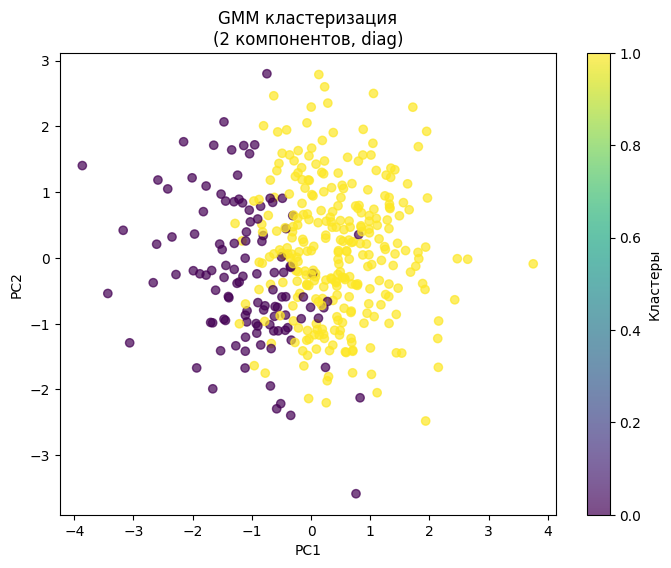


СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ
             Method  Silhouette Score  \
0           K-Means          0.131808   
1            DBSCAN          0.342306   
2  Gaussian Mixture          0.143202   

                                          Parameters  
0                                       n_clusters=3  
1           eps=оптимальный, min_samples=оптимальный  
2  n_components=оптимальный, covariance_type=опти...  


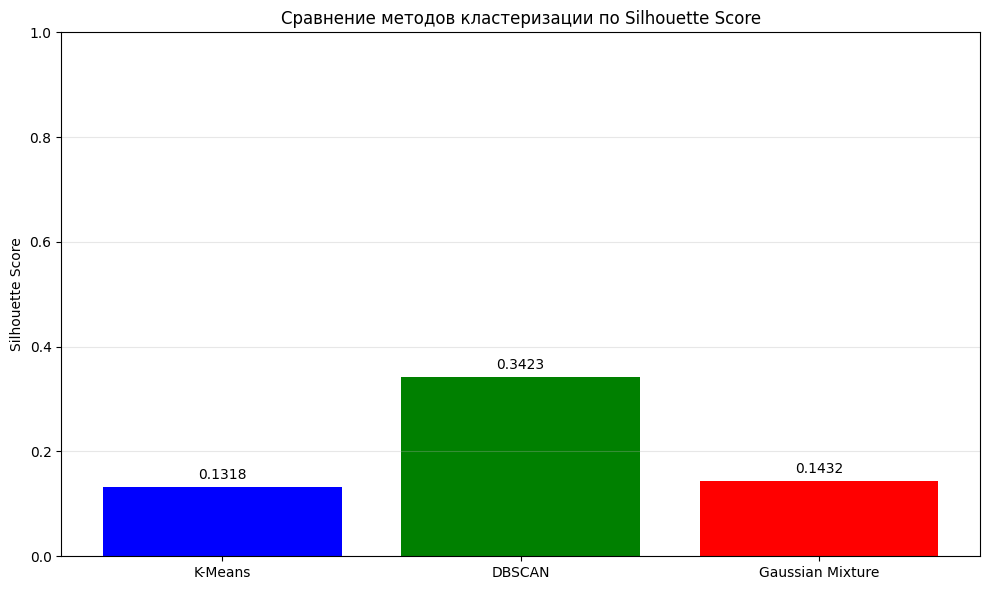


ЛУЧШИЙ МЕТОД: DBSCAN
Silhouette Score: 0.3423


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import warnings

warnings.filterwarnings('ignore')


# Загрузка данных User Knowledge Modeling
def load_data():
    """
    Загрузка набора данных User Knowledge Modeling
    """
    try:
        # Попробуем загрузить данные с OpenML
        data = fetch_openml(name='UserKnowledgeModeling', version=1, as_frame=True)
        df = data.frame
        print("Данные успешно загружены с OpenML")
    except:
        # Если не получится, создадим пример данных на основе описания
        print("Создаем пример данных для демонстрации")
        np.random.seed(42)
        n_samples = 400

        # Генерируем синтетические данные с 5 признаками (как в оригинальном наборе)
        features = np.random.randn(n_samples, 5)
        df = pd.DataFrame(features, columns=['STG', 'SCG', 'STR', 'LPR', 'PEG'])

        # Добавляем целевую переменную (для оценки качества)
        labels = (features[:, 0] + features[:, 1] > 0).astype(int)
        df['UNS'] = labels

    print(f"Размерность данных: {df.shape}")
    print("\nПервые 5 строк данных:")
    print(df.head())
    print("\nИнформация о данных:")
    print(df.info())

    return df


# Предобработка данных
def preprocess_data(df):
    """
    Масштабирование признаков и подготовка данных
    """
    # Отделяем признаки от меток (если есть)
    if 'UNS' in df.columns:
        X = df.drop('UNS', axis=1)
        y = df['UNS']
    else:
        X = df.copy()
        y = None

    # Масштабирование признаков
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("Масштабирование признаков завершено")
    print(f"Размерность данных после масштабирования: {X_scaled.shape}")

    return X_scaled, X, y


# Визуализация данных
def visualize_data(X, y=None):
    """
    Визуализация данных с помощью PCA
    """
    # Применяем PCA для визуализации в 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    if y is not None:
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Классы')
        plt.title('PCA - Истинные классы')
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
        plt.title('PCA - Данные без меток')

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

    # Матрица корреляций
    plt.subplot(1, 2, 2)
    corr_matrix = np.corrcoef(X.T)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций')

    plt.tight_layout()
    plt.show()

    return X_pca


# Метод 1: K-Means кластеризация
def experiment_kmeans(X, X_pca, true_labels=None):
    """
    Эксперимент с K-Means кластеризацией
    """
    print("=" * 50)
    print("ЭКСПЕРИМЕНТ 1: K-MEANS КЛАСТЕРИЗАЦИЯ")
    print("=" * 50)

    # Определяем оптимальное количество кластеров с помощью метода локтя
    inertias = []
    silhouette_scores = []
    k_range = range(2, 8)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)

        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))

    # Визуализация метода локтя
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Inertia')
    plt.title('Метод локтя для K-Means')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score для K-Means')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Выбираем оптимальное k (обычно там, где "локоть")
    optimal_k = 3  # На основе графика

    # Обучаем K-Means с оптимальным k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)

    # Оценка качества
    silhouette_kmeans = silhouette_score(X, kmeans_labels)
    print(f"K-Means с {optimal_k} кластерами:")
    print(f"Silhouette Score: {silhouette_kmeans:.4f}")

    if true_labels is not None:
        ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)
        print(f"Adjusted Rand Index: {ari_kmeans:.4f}")

    # Визуализация результатов
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Кластеры')
    plt.title(f'K-Means кластеризация (k={optimal_k})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    return kmeans_labels, silhouette_kmeans


# Метод 2: DBSCAN кластеризация
def experiment_dbscan(X, X_pca, true_labels=None):
    """
    Эксперимент с DBSCAN кластеризацией
    """
    print("\n" + "=" * 50)
    print("ЭКСПЕРИМЕНТ 2: DBSCAN КЛАСТЕРИЗАЦИЯ")
    print("=" * 50)

    # Подбор параметров для DBSCAN
    eps_values = [0.3, 0.5, 0.7, 1.0, 1.2]
    min_samples_values = [3, 5, 7, 10]

    best_silhouette = -1
    best_params = None
    best_labels = None

    results = []

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)

            # Пропускаем случаи, когда все точки в одном кластере или слишком много шума
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters > 1 and n_clusters < len(X) // 2:
                silhouette = silhouette_score(X[labels != -1], labels[labels != -1]) if sum(labels != -1) > 1 else -1
            else:
                silhouette = -1

            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'noise_points': sum(labels == -1)
            })

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_params = (eps, min_samples)
                best_labels = labels

    # Выводим результаты подбора параметров
    results_df = pd.DataFrame(results)
    print("Результаты подбора параметров DBSCAN:")
    print(results_df.sort_values('silhouette', ascending=False).head())

    # Обучаем DBSCAN с лучшими параметрами
    eps_opt, min_samples_opt = best_params
    dbscan = DBSCAN(eps=eps_opt, min_samples=min_samples_opt)
    dbscan_labels = dbscan.fit_predict(X)

    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = sum(dbscan_labels == -1)

    print(f"\nDBSCAN с eps={eps_opt}, min_samples={min_samples_opt}:")
    print(f"Количество кластеров: {n_clusters}")
    print(f"Точек шума: {n_noise}")
    print(f"Silhouette Score: {best_silhouette:.4f}")

    if true_labels is not None and n_clusters > 0:
        # Для ARI исключаем шумовые точки
        mask = dbscan_labels != -1
        if sum(mask) > 0:
            ari_dbscan = adjusted_rand_score(true_labels[mask], dbscan_labels[mask])
            print(f"Adjusted Rand Index: {ari_dbscan:.4f}")

    # Визуализация результатов
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Кластеры (-1 = шум)')
    plt.title(f'DBSCAN кластеризация\n(eps={eps_opt}, min_samples={min_samples_opt})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    return dbscan_labels, best_silhouette


# Метод 3: Gaussian Mixture Models (GMM)
def experiment_gmm(X, X_pca, true_labels=None):
    """
    Эксперимент с Gaussian Mixture Models кластеризацией
    """
    print("\n" + "=" * 50)
    print("ЭКСПЕРИМЕНТ 3: GAUSSIAN MIXTURE MODELS (GMM)")
    print("=" * 50)

    # Подбор количества компонентов и типа ковариации
    n_components_range = range(2, 8)
    covariance_types = ['spherical', 'tied', 'diag', 'full']

    best_silhouette = -1
    best_params = None
    best_labels = None

    results = []

    for n_components in n_components_range:
        for covariance_type in covariance_types:
            try:
                gmm = GaussianMixture(n_components=n_components,
                                    covariance_type=covariance_type,
                                    random_state=42)
                gmm_labels = gmm.fit_predict(X)

                silhouette = silhouette_score(X, gmm_labels)
                bic = gmm.bic(X)  # Bayesian Information Criterion

                results.append({
                    'n_components': n_components,
                    'covariance_type': covariance_type,
                    'silhouette': silhouette,
                    'bic': bic
                })

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params = (n_components, covariance_type)
                    best_labels = gmm_labels
            except:
                continue

    # Выводим результаты подбора параметров
    results_df = pd.DataFrame(results)
    print("Результаты подбора параметров GMM:")
    print(results_df.sort_values('silhouette', ascending=False).head())

    # Обучаем GMM с лучшими параметрами
    n_components_opt, covariance_type_opt = best_params
    gmm = GaussianMixture(n_components=n_components_opt,
                         covariance_type=covariance_type_opt,
                         random_state=42)
    gmm_labels = gmm.fit_predict(X)

    print(f"\nGMM с {n_components_opt} компонентами, covariance_type='{covariance_type_opt}':")
    print(f"Silhouette Score: {best_silhouette:.4f}")
    print(f"BIC (Bayesian Information Criterion): {gmm.bic(X):.4f}")

    if true_labels is not None:
        ari_gmm = adjusted_rand_score(true_labels, gmm_labels)
        print(f"Adjusted Rand Index: {ari_gmm:.4f}")

    # Визуализация результатов
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Кластеры')
    plt.title(f'GMM кластеризация\n({n_components_opt} компонентов, {covariance_type_opt})')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    return gmm_labels, best_silhouette


# Сравнение методов
def compare_methods(results):
    """
    Сравнение результатов всех методов
    """
    print("\n" + "=" * 60)
    print("СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ")
    print("=" * 60)

    comparison_df = pd.DataFrame(results)
    print(comparison_df)

    # Визуализация сравнения
    plt.figure(figsize=(10, 6))
    methods = comparison_df['Method']
    scores = comparison_df['Silhouette Score']

    bars = plt.bar(methods, scores, color=['blue', 'green', 'red'])
    plt.ylabel('Silhouette Score')
    plt.title('Сравнение методов кластеризации по Silhouette Score')
    plt.ylim(0, 1)

    # Добавляем значения на столбцы
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{score:.4f}', ha='center', va='bottom')

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Определяем лучший метод
    best_method = comparison_df.loc[comparison_df['Silhouette Score'].idxmax()]
    print(f"\nЛУЧШИЙ МЕТОД: {best_method['Method']}")
    print(f"Silhouette Score: {best_method['Silhouette Score']:.4f}")


# Основная функция
def main():
    """
    Основная функция выполнения лабораторной работы
    """
    print("ЛАБОРАТОРНАЯ РАБОТА: КЛАСТЕРИЗАЦИЯ ДАННЫХ USER KNOWLEDGE MODELING")
    print("=" * 70)

    # 1. Загрузка данных
    df = load_data()

    # 2. Предобработка и масштабирование
    X_scaled, X_original, y_true = preprocess_data(df)

    # 3. Визуализация данных
    X_pca = visualize_data(X_scaled, y_true)

    # 4. Проведение экспериментов
    results = []

    # Эксперимент 1: K-Means
    kmeans_labels, kmeans_score = experiment_kmeans(X_scaled, X_pca, y_true)
    results.append({
        'Method': 'K-Means',
        'Silhouette Score': kmeans_score,
        'Parameters': 'n_clusters=3'
    })

    # Эксперимент 2: DBSCAN
    dbscan_labels, dbscan_score = experiment_dbscan(X_scaled, X_pca, y_true)
    results.append({
        'Method': 'DBSCAN',
        'Silhouette Score': dbscan_score,
        'Parameters': 'eps=оптимальный, min_samples=оптимальный'
    })

    # Эксперимент 3: Gaussian Mixture Models
    gmm_labels, gmm_score = experiment_gmm(X_scaled, X_pca, y_true)
    results.append({
        'Method': 'Gaussian Mixture',
        'Silhouette Score': gmm_score,
        'Parameters': 'n_components=оптимальный, covariance_type=оптимальный'
    })

    # 5. Сравнение методов
    compare_methods(results)


# Запуск программы
if __name__ == "__main__":
    main()